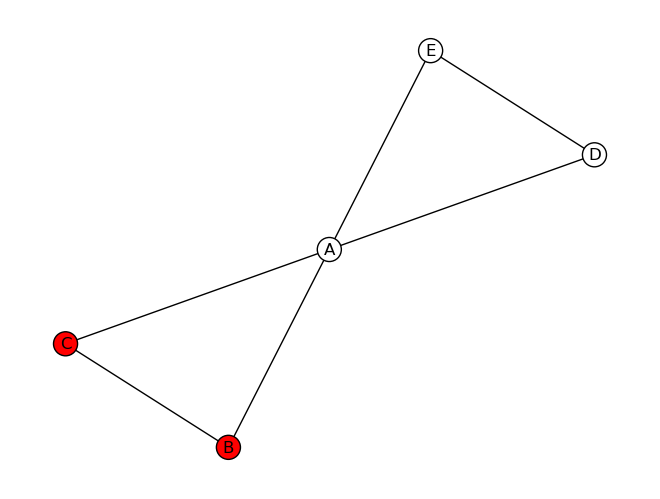

In [ ]:
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
import seaborn as sns

nodes = ["A", "B", "C", "D", "E"]
edges = [["A", "B"], ["A", "C"], ["B", "C"], ["D", "A"], ["A", "E"], ["D", "E"]]

num_nodes = len(nodes)
num_edges = len(edges)

# Create node to index mapping and edge index
node_to_idx = {node: i for i, node in enumerate(nodes)}
edge_index = [[node_to_idx[x], node_to_idx[y]] for x, y in edges]

# Reverse edges to make the graph undirected
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_index_rev = edge_index[[1,0], :]
edge_index = torch.cat([edge_index, edge_index_rev], dim=1)

# Add self-loops
self_loops = torch.arange(num_nodes, dtype=torch.long)
self_loops = torch.stack([self_loops, self_loops], dim=0)  # [2, N]
edge_index = torch.cat([edge_index, self_loops], dim=1)

node_colors = ['white', 'red', 'red', 'white', 'white']

# Get the RGBA for each color
node_colors = [mcolors.to_rgba(color) for color in node_colors]

def plot_graph(nodes, edges, node_colors):
    
    # Create a graph using NetworkX
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Draw the graph, outlining the nodes in black
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edgecolors='black')

    plt.show()
    
plot_graph(nodes, edges, node_colors)

### Message Passing and Normalization

Aggregates the incoming node embeddings for each node in the graph.

Normalizes the message being passed between neighbors using the inverse square root of the connection degree for the source * the destination nodes. 

In [ ]:
# Get the RGB values as a tensor
rgb = torch.tensor(node_colors, dtype=torch.float)[:, :3]
src, dst = edge_index
N = rgb.size(0)

def gcn_norm_from_node_degree(src, dst, N, rgb):
    deg = torch.zeros(N, dtype=rgb.dtype, device=rgb.device)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=rgb.dtype, device=rgb.device))
     
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    
    norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]  # [E]
     
    return norm

# Linear transformation
W = torch.nn.Linear(3, 3, bias=False)

# Pass the colors through the linear layer
x = W(rgb)

norm = gcn_norm_from_node_degree(src, dst, N, x)

# Normalize the messages based on connected node degrees
messages = x[src] * norm.unsqueeze(1)

# Aggregate normalized messages at destination nodes
agg = torch.zeros_like(x)
agg.index_add_(0, dst, messages)

# Apply non-linearity function to the message
out = torch.relu(agg)

print("out:", out)

out: tensor([[0.0000, 0.2468, 0.0000],
        [0.0348, 0.0000, 0.0000],
        [0.0348, 0.0000, 0.0000],
        [0.0000, 0.4606, 0.0000],
        [0.0000, 0.4606, 0.0000]], grad_fn=<ReluBackward0>)


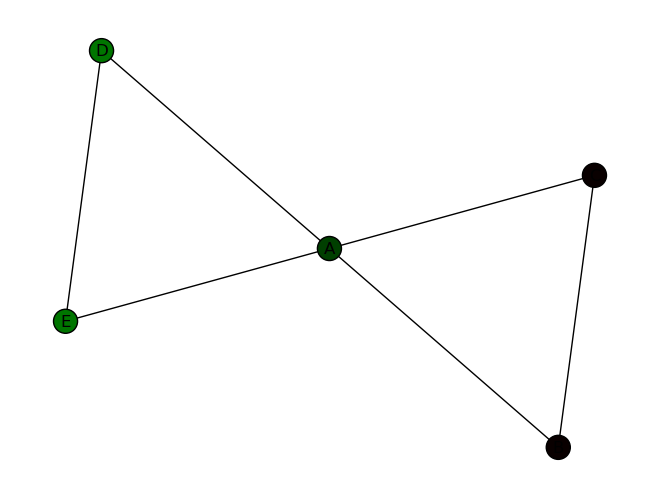

In [209]:
plot_graph(nodes, edges, out.detach().numpy())

### Final linear transform after message passing and aggregation

In [171]:
W = torch.nn.Linear(F, F, bias=False)
out = W(aggregated_messages)

In [158]:
new_node_colors = []
print(node_colors)
for i, node in enumerate(node_colors):
    node_list = list(node)
    for j in range(3):
        node_list[j] = float(np.clip(node_list[j] + out[i][j].item(), 0.0, 1.0))
    new_node_colors.append(tuple(node_list))

print(new_node_colors)
    

[(1.0, 1.0, 1.0, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0)]
[(1.0, 1.0, 1.0, 1.0), (1.0, 0.06996084004640579, 0.10380854457616806, 1.0), (1.0, 0.06996084004640579, 0.10380854457616806, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0)]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

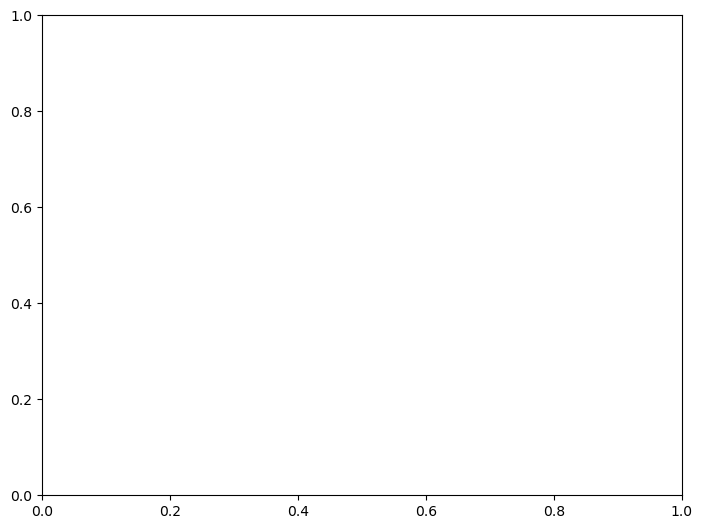

In [173]:
# Visualize the graph with new node colors and edge strengths
plot_graph(nodes, edges, new_colors)

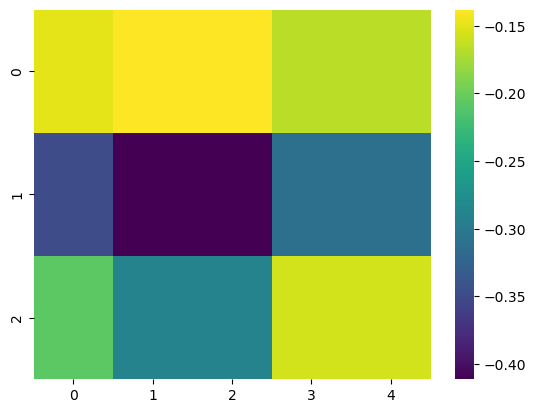

In [118]:
sns.heatmap(node_embedding.detach().numpy().T, cmap="viridis")
plt.show()